In [1]:
import functools
import os
import concurrent.futures

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import healsparse
from scipy import stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree

In [3]:
import lib

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"

In [5]:
rng = np.random.default_rng(0)

In [6]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [7]:
redshift_sim_plus = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step_plus],
)

In [8]:
redshift_sim_minus = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step_minus],
)

In [9]:
shear_sim_plus = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step_plus],
)

In [10]:
shear_sim_minus = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step_minus],
)

In [11]:
truth_match_plus = h5py.File(
    lib.const.SIM_MATCH_CATALOGS[shear_step_plus],
)

In [12]:
truth_match_minus = h5py.File(
    lib.const.SIM_MATCH_CATALOGS[shear_step_minus],
)

In [13]:
_, shear_sim_index_plus, redshift_sim_index_plus = np.intersect1d(
    shear_sim_plus["mdet/noshear"]["uid"][:],
    redshift_sim_plus["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [14]:
_, shear_sim_index_minus, redshift_sim_index_minus = np.intersect1d(
    shear_sim_minus["mdet/noshear"]["uid"][:],
    redshift_sim_minus["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [15]:
np.testing.assert_equal(
    shear_sim_plus["mdet/noshear"]["uid"][:][shear_sim_index_plus],
    redshift_sim_plus["sompz/noshear"]["coadd_object_id"][:][redshift_sim_index_plus],
)

In [16]:
bhat_sim_plus = np.full(shear_sim_plus["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim_plus[shear_sim_index_plus] = redshift_sim_plus["sompz/noshear"]["bhat"][:][redshift_sim_index_plus]

In [17]:
bhat_sim_minus = np.full(shear_sim_minus["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim_minus[shear_sim_index_minus] = redshift_sim_minus["sompz/noshear"]["bhat"][:][redshift_sim_index_minus]

In [18]:
cell_sim_plus = np.full(shear_sim_plus["mdet/noshear"]["uid"].shape, np.nan)
cell_sim_plus[shear_sim_index_plus] = redshift_sim_plus["sompz/noshear"]["cell_wide"][:][redshift_sim_index_plus]

In [19]:
cell_sim_minus = np.full(shear_sim_minus["mdet/noshear"]["uid"].shape, np.nan)
cell_sim_minus[shear_sim_index_minus] = redshift_sim_minus["sompz/noshear"]["cell_wide"][:][redshift_sim_index_minus]

In [20]:
weight_sim_plus = lib.weight.get_shear_weights(shear_sim_plus["mdet/noshear"])

In [21]:
weight_sim_minus = lib.weight.get_shear_weights(shear_sim_minus["mdet/noshear"])

---

In [22]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [23]:
_, shear_y6_index, redshift_y6_index = np.intersect1d(
    shear_y6["mdet/noshear"]["uid"][:],
    redshift_y6["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [24]:
bhat_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
bhat_y6[shear_y6_index] = redshift_y6["sompz/noshear"]["bhat"][:][redshift_y6_index]

In [25]:
cell_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
cell_y6[shear_y6_index] = redshift_y6["sompz/noshear"]["cell_wide"][:][redshift_y6_index]

In [26]:
weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet/noshear"])

In [27]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        cell_y6[bhat_y6 == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

---

In [28]:
sel_sim_plus = np.isin(
    cell_sim_plus,
    cell_assignments[0],
)

In [29]:
sel_sim_minus = np.isin(
    cell_sim_minus,
    cell_assignments[0],
)

In [30]:
sel_y6 = np.isin(
    cell_y6,
    cell_assignments[0],
)

In [31]:
_weight_sim_plus = weight_sim_plus[sel_sim_plus]

In [32]:
_weight_sim_minus = weight_sim_minus[sel_sim_minus]

In [33]:
_mag_sim_plus = lib.util.flux_to_mag(
    np.mean(
        [
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_r"][sel_sim_plus],
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_i"][sel_sim_plus],
            shear_sim_plus["mdet/noshear"]["pgauss_band_flux_z"][sel_sim_plus],
        ],
        axis=0,
    )
)

In [34]:
_mag_sim_minus = lib.util.flux_to_mag(
    np.mean(
        [
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_r"][sel_sim_minus],
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_i"][sel_sim_minus],
            shear_sim_minus["mdet/noshear"]["pgauss_band_flux_z"][sel_sim_minus],
        ],
        axis=0,
    )
)

In [35]:
_points_sim_plus = np.deg2rad(
    np.stack(
        [shear_sim_plus["mdet/noshear"]["ra"][sel_sim_plus], shear_sim_plus["mdet/noshear"]["dec"][sel_sim_plus]],
        axis=-1,
    )
)

In [36]:
_points_sim_minus = np.deg2rad(
    np.stack(
        [shear_sim_minus["mdet/noshear"]["ra"][sel_sim_minus], shear_sim_minus["mdet/noshear"]["dec"][sel_sim_minus]],
        axis=-1,
    )
)

In [37]:
_mag_y6 = lib.util.flux_to_mag(
    np.mean(
        [
            shear_y6["mdet/noshear"]["pgauss_band_flux_r"][sel_y6],
            shear_y6["mdet/noshear"]["pgauss_band_flux_i"][sel_y6],
            shear_y6["mdet/noshear"]["pgauss_band_flux_z"][sel_y6],
        ],
        axis=0,
    )
)

In [38]:
_points_y6 = np.deg2rad(
    np.stack(
        [shear_y6["mdet/noshear"]["ra"][sel_y6], shear_y6["mdet/noshear"]["dec"][sel_y6]],
        axis=-1
    )
)

In [39]:
bt_sim_plus = BallTree(
    _points_sim_plus,
    metric="haversine",
)

In [40]:
bt_sim_minus = BallTree(
    _points_sim_minus,
    metric="haversine",
)

In [41]:
bt_y6 = BallTree(
    _points_y6,
    metric="haversine",
)

In [42]:
N_SUBSAMPLE = 200_000

_sim_subsample_plus = rng.choice(sum(sel_sim_plus), N_SUBSAMPLE // 2, replace=False)
_sim_subsample_minus = rng.choice(sum(sel_sim_minus), N_SUBSAMPLE // 2, replace=False)

_y6_subsample = rng.choice(sum(sel_y6), N_SUBSAMPLE, replace=False)

sim_subsample_plus = np.isin(
    np.arange(sum(sel_sim_plus)),
    _sim_subsample_plus,
)
sim_subsample_minus = np.isin(
    np.arange(sum(sel_sim_minus)),
    _sim_subsample_minus,
)

y6_subsample = np.isin(
    np.arange(sum(sel_y6)),
    _y6_subsample,
)

In [43]:
dist_sim_plus, ind_sim_plus = bt_sim_plus.query(
    _points_sim_plus[sim_subsample_plus],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [44]:
dist_sim_minus, ind_sim_minus = bt_sim_minus.query(
    _points_sim_minus[sim_subsample_minus],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [45]:
dist_y6, ind_y6 = bt_y6.query(
    _points_y6[y6_subsample],
    k=2,
    return_distance=True,  # default, but we depend on this behavior
    sort_results=True,  # default, but we depend on this behavior
)

In [46]:
neighbor_distance_sim_plus = dist_sim_plus[:, 1]
source_magnitude_sim_plus = _mag_sim_plus[ind_sim_plus[:, 0]]
neighbor_magnitude_sim_plus = _mag_sim_plus[ind_sim_plus[:, 1]]
weight_sim_plus = _weight_sim_plus[ind_sim_plus[:, 0]]

In [47]:
neighbor_distance_sim_minus = dist_sim_minus[:, 1]
source_magnitude_sim_minus = _mag_sim_minus[ind_sim_minus[:, 0]]
neighbor_magnitude_sim_minus = _mag_sim_minus[ind_sim_minus[:, 1]]
weight_sim_minus = _weight_sim_minus[ind_sim_minus[:, 0]]

In [48]:
# distances_y6 = np.rad2deg(dist_y6)

In [49]:
# neighbor_distance_y6 = distances_y6[:, 1] * 60 * 60
neighbor_distance_y6 = dist_y6[:, 1]
source_magnitude_y6 = _mag_y6[ind_y6[:, 0]]
neighbor_magnitude_y6 = _mag_y6[ind_y6[:, 1]]

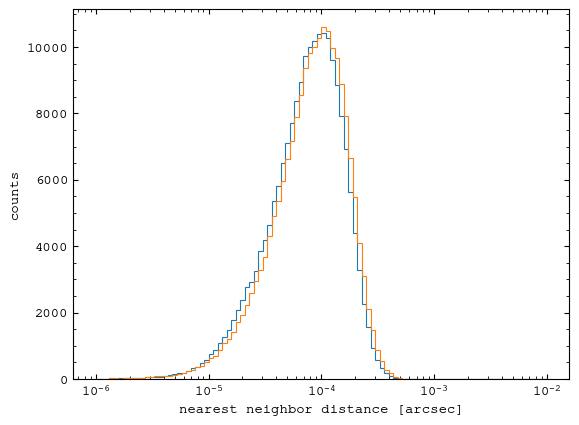

In [50]:
# bins = np.geomspace(1e0, 1e2, 101)
NBINS = 100
bins = np.geomspace(1e-6, 1e-2, NBINS + 1)

fig, axs = plt.subplots(1, 1)

axs.hist(neighbor_distance_y6, bins=bins, histtype="step")
axs.hist(
    np.concatenate([neighbor_distance_sim_plus, neighbor_distance_sim_minus]),
    bins=bins,
    histtype="step",
)


axs.set_xscale("log")

axs.set_xlabel("nearest neighbor distance [arcsec]")
axs.set_ylabel("counts")

fig.show()

In [51]:
X_sim = np.concatenate(
    [
        np.stack([np.log10(neighbor_distance_sim_plus), source_magnitude_sim_plus, neighbor_magnitude_sim_plus], axis=-1),
        np.stack([np.log10(neighbor_distance_sim_minus), source_magnitude_sim_minus, neighbor_magnitude_sim_minus], axis=-1),
    ],
)
W_sim = np.concatenate(
    [weight_sim_plus, weight_sim_minus],
)
X_y6 = np.stack([np.log10(neighbor_distance_y6), source_magnitude_y6, neighbor_magnitude_y6], axis=-1)

In [52]:
scaler = preprocessing.StandardScaler().fit(X_sim)

In [53]:
ns = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
inertias = []
for n in ns:
    kmeans = KMeans(
        n_clusters=n,
        random_state=0,
    ).fit(
        scaler.transform(X_sim),
        sample_weight=W_sim,
    )
    inertias.append(kmeans.inertia_)

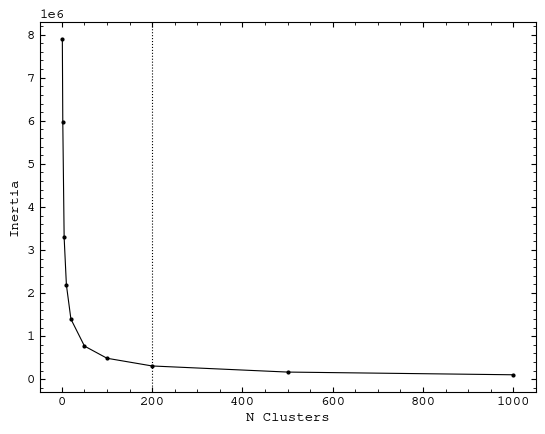

In [54]:
plt.axvline(200, ls=":")
plt.plot(
    ns,
    inertias,
    marker="o",
    markersize=2,
    c="k",
)
plt.xlabel("N Clusters")
plt.ylabel("Inertia")
# plt.loglog()
plt.show()

In [55]:
N_CLUSTERS = 200

In [56]:
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=0,
).fit(
    scaler.transform(X_sim),
    sample_weight=W_sim,
)

In [57]:
# y_sim = kmeans.predict(scaler.transform(X_sim))

X_sim_plus = np.stack([np.log10(neighbor_distance_sim_plus), source_magnitude_sim_plus, neighbor_magnitude_sim_plus], axis=-1)
y_sim_plus = kmeans.predict(scaler.transform(X_sim_plus))

X_sim_minus = np.stack([np.log10(neighbor_distance_sim_minus), source_magnitude_sim_minus, neighbor_magnitude_sim_minus], axis=-1)
y_sim_minus = kmeans.predict(scaler.transform(X_sim_minus))

In [58]:
y_y6 = kmeans.predict(scaler.transform(X_y6))

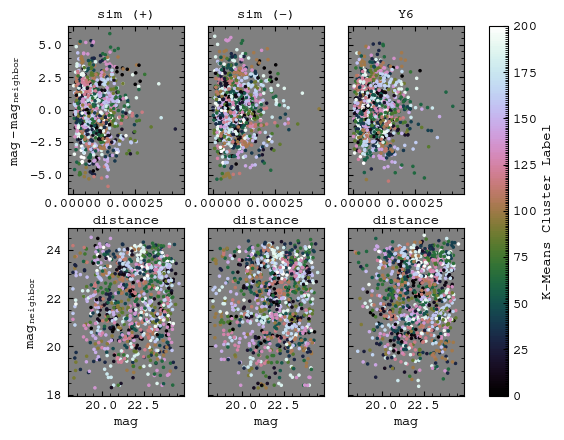

In [61]:
cmap = mpl.cm.cubehelix
bounds = np.unique(kmeans.labels_)
bounds = np.append(bounds, bounds[-1] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

N_SUBSAMPLE = 1_000
_sim_subsample_plus = rng.choice(len(X_sim_plus), N_SUBSAMPLE, replace=False)
_sim_subsample_minus = rng.choice(len(X_sim_minus), N_SUBSAMPLE, replace=False)

_y6_subsample = rng.choice(len(X_y6), N_SUBSAMPLE, replace=False)

fig, axs = plt.subplots(2, 3, sharex="row", sharey="row")

for ax in axs.ravel():
    ax.set_facecolor("grey")

axs[0, 0].scatter(
    10**X_sim_plus[_sim_subsample_plus, 0],
    X_sim_plus[_sim_subsample_plus, 1] - X_sim_plus[_sim_subsample_plus, 2],
    c=y_sim_plus[_sim_subsample_plus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 0].set_xlabel("distance")
axs[0, 0].set_ylabel("$mag - mag_{neighbor}$")

axs[0, 1].scatter(
    10**X_sim_minus[_sim_subsample_minus, 0],
    X_sim_minus[_sim_subsample_minus, 1] - X_sim_minus[_sim_subsample_minus, 2],
    c=y_sim_minus[_sim_subsample_minus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 1].set_xlabel("distance")
# axs[0, 1].set_ylabel("$mag - mag_{neighbor}$")

axs[0, 2].scatter(
    10**X_y6[_y6_subsample, 0],
    X_y6[_y6_subsample, 1] - X_y6[_y6_subsample, 2],
    c=y_y6[_y6_subsample],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[0, 2].set_xlabel("distance")
# axs[0, 2].set_ylabel("$mag - mag_{neighbor}$")

axs[1, 0].scatter(
    X_sim_plus[_sim_subsample_plus, 1],
    X_sim_plus[_sim_subsample_plus, 2],
    c=y_sim_plus[_sim_subsample_plus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 0].set_xlabel("$mag$")
axs[1, 0].set_ylabel("$mag_{neighbor}$")

axs[1, 1].scatter(
    X_sim_minus[_sim_subsample_minus, 1],
    X_sim_minus[_sim_subsample_minus, 2],
    c=y_sim_minus[_sim_subsample_minus],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 1].set_xlabel("$mag$")
# axs[1, 1].set_ylabel("$mag_{neighbor}$")

axs[1, 2].scatter(
    X_y6[_y6_subsample, 1],
    X_y6[_y6_subsample, 2],
    c=y_y6[_y6_subsample],
    cmap=cmap,
    norm=norm,
    s=12,
)
axs[1, 2].set_xlabel("$mag$")
# axs[1, 2].set_ylabel("$mag_{neighbor}$")

axs[0, 0].set_title("sim (+)")
axs[0, 1].set_title("sim (-)")
axs[0, 2].set_title("Y6")

# fig.supxlabel("nearest neighbor distance [arcsec]")
# fig.supylabel("$mag - mag_{neighbor}$")

cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel(),
    label="K-Means Cluster Label",
    spacing="proportional",
)
cb.locator = mpl.ticker.MaxNLocator(nbins="auto", integer=True)
cb.minor_locator = mpl.ticker.NullLocator()

plt.show()

---

In [73]:
w_bins = np.unique(y_y6)

In [74]:
w_plus = np.bincount(y_y6) / np.bincount(y_sim_plus)
w_plus /= np.mean(w_plus)

# # fix bins that don't have assignments
# ww[ww==0.] = 1.
# ww[ww>5.] = 5.

In [75]:
w_minus = np.bincount(y_y6) / np.bincount(y_sim_minus)
w_minus /= np.mean(w_minus)

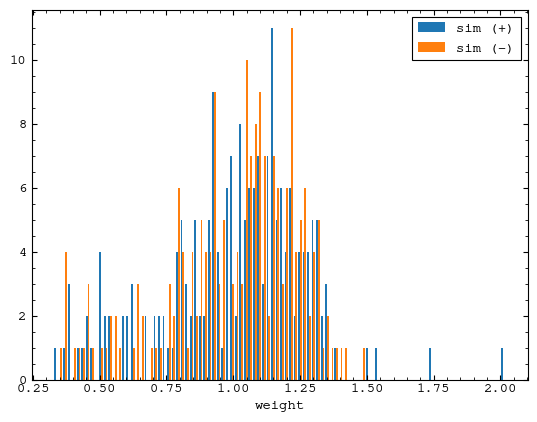

In [77]:
plt.hist(
    [w_plus, w_minus],
    label=["sim (+)", "sim (-)"],
    bins=100,
)
plt.xlabel("weight")
plt.legend()
plt.show()

---

In [ ]:
tilenames = np.unique(shear_sim["mdet/noshear"]["tilename"][:].astype(str))

In [ ]:
mdet_mask = lib.util.load_mdet_mask()
mdet_area = mdet_mask.get_valid_area()

In [ ]:
def accumulate_area(tile, mdet_mask):
    tile_area = lib.util.get_tile_area(
        tile,
        "r",
        shear="plus",
        mdet_mask=mdet_mask,
    )

    return tile_area

In [ ]:
def accumulate_hist(shear, bhat, bins, tomographic_bin=None, tile=None):
    # plus
    in_tile = shear["mdet/noshear"]["tilename"][:].astype(str) == tile
    in_tomo = bhat == tomographic_bin
    sel = in_tile & in_tomo

    matcher = smatch.Matcher(shear["mdet/noshear"]["ra"][sel], shear["mdet/noshear"]["dec"][sel])
    indices, distances = matcher.query_knn(matcher.lon, matcher.lat, k=2, return_distances=True)
    dnn = distances[:, 1] * 60 * 60
    del matcher, indices, distances

    hist, _ = np.histogram(dnn, bins=bins)
    del dnn

    return hist

In [ ]:
def accumulate_hist_rand(shear, bhat, bins, mdet_mask, tomographic_bin=None, tile=None):
    # plus
    in_tile = shear["mdet/noshear"]["tilename"][:].astype(str) == tile
    in_tomo = bhat == tomographic_bin
    sel = in_tile & in_tomo

    tile_map = lib.util.get_tile_mask(
        tile,
        "r",
        shear="plus",
        mdet_mask=mdet_mask,
    )

    n_sample = np.sum(sel)

    rand_ra, rand_dec = healsparse.make_uniform_randoms(tile_map, n_sample)
    del tile_map

    rand_matcher = smatch.Matcher(rand_ra, rand_dec)
    rand_indices, rand_distances = rand_matcher.query_knn(rand_matcher.lon, rand_matcher.lat, k=2, return_distances=True)
    rand_dnn = rand_distances[:, 1] * 60 * 60
    del rand_matcher, rand_indices, rand_distances

    rand_hist, _ = np.histogram(rand_dnn, bins=bins)
    del rand_dnn

    return rand_hist

In [ ]:
NBINS = 100 
bins = np.geomspace(1e-2, 2, NBINS + 1) * 60

In [ ]:
hist_y6 = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    sel = bhat_y6 == tomographic_bin
  
    matcher = smatch.Matcher(shear_y6["mdet/noshear"]["ra"][sel], shear_y6["mdet/noshear"]["dec"][sel])
    indices, distances = matcher.query_knn(matcher.lon, matcher.lat, k=2, return_distances=True)
    dnn = distances[:, 1] * 60 * 60
    del matcher, indices, distances  # forecfully cleanup
    _hist, _ = np.histogram(dnn, bins=bins)
    

    hist_y6[tomographic_bin] = _hist / mdet_area

In [ ]:
N_TEST = len(tilenames)

In [ ]:
area_futures = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    for i, tile in enumerate(tilenames[:N_TEST]):
        _future = executor.submit(
            accumulate_area,
            tile,
            mdet_mask,
        )
        area_futures[tile] = _future

In [ ]:
hist_futures = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_futures[tomographic_bin] = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, tile in enumerate(tilenames[:N_TEST]):
            _future = executor.submit(
                accumulate_hist,
                shear_sim,
                bhat_sim,
                bins,
                tomographic_bin,
                tile,
            )
            hist_futures[tomographic_bin][tile] = _future

In [ ]:
hist_rand_futures = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_rand_futures[tomographic_bin] = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, tile in enumerate(tilenames[:N_TEST]):
            _future = executor.submit(
                accumulate_hist_rand,
                shear_sim,
                bhat_sim,
                bins,
                mdet_mask,
                tomographic_bin,
                tile,
            )
            hist_rand_futures[tomographic_bin][tile] = _future

In [ ]:
# hist_sim = {
#     tomographic_bin: np.zeros(NBINS)
#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
# }
# hist_rand = {
#     tomographic_bin: np.zeros(NBINS)
#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
# }
# area = 0

# for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#     for tile in tilenames:
#         if (
#             (_hist_future := hist_futures[tomographic_bin].get(tile)) is not None
#         ) and (
#             (_hist_rand_future := hist_rand_futures[tomographic_bin].get(tile)) is not None
#         ):
#             _hist = _hist_future.result()
#             _hist_rand = _hist_rand_future.result()
            
#             hist_sim[tomographic_bin] = np.nansum([hist_sim[tomographic_bin], _hist], axis=0)
#             hist_rand[tomographic_bin] = np.nansum([hist_rand[tomographic_bin], _hist_rand], axis=0)

# for tile in tilenames:
#     if (_area_future := area_futures.get(tile)) is not None:
#         _area = _area_future.result()
#         area += _area

# for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#     hist_sim[tomographic_bin] = hist_sim[tomographic_bin] / area
#     hist_rand[tomographic_bin] = hist_rand[tomographic_bin] / area

In [ ]:
hist_sim = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}
hist_rand = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    for tile in tilenames:
        if (
            (_hist_future := hist_futures[tomographic_bin].get(tile)) is not None
        ) and (
            (_hist_rand_future := hist_rand_futures[tomographic_bin].get(tile)) is not None
        ) and (
            (_area_future := area_futures.get(tile)) is not None
        ):
            _hist = _hist_future.result()
            _hist_rand = _hist_rand_future.result()
            _area = _area_future.result()

            hist_sim[tomographic_bin] = np.nansum([hist_sim[tomographic_bin], _hist / _area], axis=0)
            hist_rand[tomographic_bin] = np.nansum([hist_rand[tomographic_bin], _hist_rand / _area], axis=0)
            
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_sim[tomographic_bin] = hist_sim[tomographic_bin] / len(tilenames)
    hist_rand[tomographic_bin] = hist_rand[tomographic_bin] / len(tilenames)

In [ ]:
# hist_sim = {
#     tomographic_bin: np.zeros(NBINS)
#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
# }
# hist_rand = {
#     tomographic_bin: np.zeros(NBINS)
#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
# }
# area = 0

# # harmonic mean
# for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#     _numerator_sim = np.zeros(NBINS)
#     _numerator_rand = np.zeros(NBINS)
#     _denominator_sim = np.zeros(NBINS)
#     _denominator_rand = np.zeros(NBINS)
#     for tile in tilenames:
#         if (
#             (_hist_future := hist_futures[tomographic_bin].get(tile)) is not None
#         ) and (
#             (_hist_rand_future := hist_rand_futures[tomographic_bin].get(tile)) is not None
#         ) and (
#             (_area_future := area_futures.get(tile)) is not None
#         ):
#             _hist = _hist_future.result()
#             _hist_rand = _hist_rand_future.result()
#             _area = _area_future.result()

#             _numerator_sim = np.nansum([_numerator_sim, np.where(_hist > 0, 1, 0)], axis=0)
#             _numerator_rand = np.nansum([_numerator_rand, np.where(_hist_rand > 0, 1, 0)], axis=0)
#             _denominator_sim = np.nansum([_denominator_sim, np.where(_hist > 0, _area / _hist, np.nan)], axis=0)
#             _denominator_rand = np.nansum([_denominator_rand, np.where(_hist_rand > 0, _area / _hist_rand, np.nan)], axis=0)

#     hist_sim[tomographic_bin] = np.where(_denominator_sim > 0, _numerator_sim / _denominator_sim, 0)
#     hist_rand[tomographic_bin] = np.where(_denominator_rand > 0, _numerator_rand / _denominator_rand, 0)

In [ ]:
# stats.hmean(
#     np.array([
#         hist_res.result() / area_res.result()
#         for (hist_res, area_res)
#         in zip(hist_futures[tomographic_bin].values(), area_futures.values())
#     ]),
#     axis=0,
# )

In [ ]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].stairs(
        hist_y6[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    axs[tomographic_bin].stairs(
        hist_rand[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    axs[tomographic_bin].stairs(
        hist_sim[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(0, None)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("density [$counts / deg^2$]")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

In [ ]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    contour1d(
        axs[tomographic_bin],
        hist_y6[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    contour1d(
        axs[tomographic_bin],
        hist_rand[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[tomographic_bin],
        hist_sim[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(0, None)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("density [$counts / deg^2$]")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

In [ ]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    axs[tomographic_bin].stairs(
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    axs[tomographic_bin].stairs(
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

In [ ]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    contour1d(
        axs[tomographic_bin],
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[tomographic_bin],
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

In [ ]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    2, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 6),
    sharex=True,
    sharey="row",
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    contour1d(
        axs[0, tomographic_bin],
        hist_y6[tomographic_bin],
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    contour1d(
        axs[0, tomographic_bin],
        hist_rand[tomographic_bin],
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[0, tomographic_bin],
        hist_sim[tomographic_bin],
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )

    axs[1, tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    contour1d(
        axs[1, tomographic_bin],
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[1, tomographic_bin],
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    
# axs[0, 0].legend(loc="upper left")
# axs[1, 0].legend(loc="upper left")

axs[0, 0].set_xscale("log")
axs[0, 0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0, 0].set_ylim(0, None)

axs[1, 0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")

axs[0, 0].set_ylabel("density [$counts / deg^2$]")
axs[1, 0].set_ylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[1, 3].legend(lines, labels, loc="upper left")

watermark(fig)

fig.savefig("tomographic-clustering.pdf")

plt.show()

In [ ]:
with h5py.File("clustering.hdf5", "w") as hf:
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        tomo_group = hf.create_group(f"bin{tomographic_bin}")
        for group in ["Y6", "rand", "sim"]:
            data_group = tomo_group.create_group(group)
            data_group.create_dataset("density", data=hist_sim[tomographic_bin])
            data_group.create_dataset("bins", data=bins)